In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

data_dir = Path("../data")
president_csv = data_dir / "president.csv"
president_rates_csv = data_dir / "president_rates.csv"
president_rates_fth = data_dir / "president_rates.fth"
president_changes_fth = data_dir / "president_changes.fth"
president_changes_csv = data_dir / "president_changes.csv"

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)

# Data

In [2]:
votes = pd.read_csv(president_csv,
                    dtype={
                        "RECEIVED_VOTES": np.int32,
                        "VALID_VOTES": np.int32,
                        "INVALID_VOTES": np.int32,
                        "ISSUED_VOTES": np.int32,
                        "UNISSUED_VOTES": np.int32,
                        "POPULATION": np.int32,
                        "VOTING_RATE": np.float32,
                    }); votes

,YEAR,CITY_COUNTY,TOWNSHIP_CITY,VILLAGE,BOOTH_NUMBER,CANDIDATE,PARTY,RECEIVED_VOTES,VALID_VOTES,INVALID_VOTES,ISSUED_VOTES,UNISSUED_VOTES,POPULATION,VOTING_RATE
0,2008,臺北市,北投區,建民里,1,(1)謝長廷蘇貞昌,DPP,711,1312,12,1324,359,1683,78.669998
1,2008,臺北市,北投區,建民里,1,(2)馬英九蕭萬長,KMT,601,1312,12,1324,359,1683,78.669998
2,2008,臺北市,北投區,建民里,2,(1)謝長廷蘇貞昌,DPP,685,1391,4,1395,333,1728,80.730003
3,2008,臺北市,北投區,建民里,2,(2)馬英九蕭萬長,KMT,706,1391,4,1395,333,1728,80.730003
4,2008,臺北市,北投區,文林里,3,(1)謝長廷蘇貞昌,DPP,458,940,6,946,234,1180,80.169998
5,2008,臺北市,北投區,文林里,3,(2)馬英九蕭萬長,KMT,482,940,6,946,234,1180,80.169998
6,2008,臺北市,北投區,文林里,4,(1)謝長廷蘇貞昌,DPP,485,1103,9,1112,192,1304,85.279999
7,2008,臺北市,北投區,文林里,4,(2)馬英九蕭萬長,KMT,618,1103,9,1112,192,1304,85.279999
8,2008,臺北市,北投區,文林里,5,(1)謝長廷蘇貞昌,DPP,435,995,5,1000,233,1233,81.099998
9,2008,臺北市,北投區,文林里,5,(2)馬英九蕭萬長,KMT,560,995,5,1000,233,1233,81.099998


In [12]:
def compute_rates(votes):
    df = votes.copy()
    df = df.drop(df[df.PARTY == "PFP"].index)
    for col in ["BOOTH_NUMBER", "CANDIDATE", "VALID_VOTES", "INVALID_VOTES", "UNISSUED_VOTES",
                "POPULATION", "VOTING_RATE"]:
        del df[col]
    rates = df.groupby(
        ["CITY_COUNTY", "TOWNSHIP_CITY", "VILLAGE", "PARTY", "YEAR"]
    ).aggregate({
        "RECEIVED_VOTES": "sum",
        "ISSUED_VOTES": "sum",
    })
    rates["RATE"] = rates.RECEIVED_VOTES / rates.ISSUED_VOTES
    return rates

rates = compute_rates(votes); display_all(rates)

RECEIVED_VOTES  ISSUED_VOTES  \
CITY_COUNTY TOWNSHIP_CITY VILLAGE PARTY YEAR                                 
南投縣         中寮鄉           中寮村     DPP   2008             150           514   
                                        2012             199           469   
                                        2016             189           372   
                                  KMT   2008             360           514   
                                        2012             261           469   
...                                                      ...           ...   
高雄縣         鳳山市           鳳崗里     KMT   2008             540           916   
                          鳳東里     DPP   2008            1583          3363   
                                  KMT   2008            1762          3363   
                          龍成里     DPP   2008            1140          2097   
                                  KMT   2008             922          2097   

                                                  RATE  
CITY_COUNTY TOWNSHIP_CITY VILLAGE PARTY YEAR            
南投縣         中寮鄉           中寮村     DPP   2008  0.291829  
                                        2012  0.424307  
                                        2016  0.508065  
                                  KMT   2008  0.700389  
                                        2012  0.556503  
...                                                ...  
高雄縣         鳳山市           鳳崗里     KMT   2008  0.589520  
                          鳳東里     DPP   2008  0.470711  
                                  KMT   2008  0.523937  
                          龍成里     DPP   2008  0.543634  
                                  KMT   2008  0.439676  

[46860 rows x 3 columns]

In [19]:
rates.reset_index().to_csv(president_rates_csv, index=None)
rates.reset_index().to_feather(president_rates_fth)

# Explore

In [4]:
from sqlalchemy import create_engine

POSTGRES_HOST = "localhost"
POSTGRES_PORT = "5432"
POSTGRES_USER = "postgres"
POSTGRES_PASSWORD = "mysecret"
POSTGRES_DBNAME = "mydb"

postgres_str = "postgresql://{user}:{password}@{host}:{port}/{dbname}".format(
    user=POSTGRES_USER, password=POSTGRES_PASSWORD, host=POSTGRES_HOST, port=POSTGRES_PORT, dbname=POSTGRES_DBNAME)

conn = create_engine(postgres_str) 

In [5]:
pd.read_sql_query("SELECT * FROM rates LIMIT 10;", conn)

,city_county,township_city,village,party,year,received_votes,issued_votes,rate
0,南投縣,中寮鄉,中寮村,DPP,2008,150,514,0.291829
1,南投縣,中寮鄉,中寮村,DPP,2012,199,469,0.424307
2,南投縣,中寮鄉,中寮村,DPP,2016,189,372,0.508065
3,南投縣,中寮鄉,中寮村,KMT,2008,360,514,0.700389
4,南投縣,中寮鄉,中寮村,KMT,2012,261,469,0.556503
5,南投縣,中寮鄉,中寮村,KMT,2016,132,372,0.354839
6,南投縣,中寮鄉,內城村,DPP,2008,115,313,0.367412
7,南投縣,中寮鄉,內城村,DPP,2012,137,307,0.446254
8,南投縣,中寮鄉,內城村,DPP,2016,140,267,0.524345
9,南投縣,中寮鄉,內城村,KMT,2008,195,313,0.623003


In [7]:
pd.read_sql_query("SELECT * FROM rates WHERE village = '南津里';", conn)

,city_county,township_city,village,party,year,received_votes,issued_votes,rate
0,宜蘭縣,宜蘭市,南津里,DPP,2008,353,696,0.507184
1,宜蘭縣,宜蘭市,南津里,DPP,2012,397,744,0.533602
2,宜蘭縣,宜蘭市,南津里,DPP,2016,516,1209,0.426799
3,宜蘭縣,宜蘭市,南津里,KMT,2008,338,696,0.485632
4,宜蘭縣,宜蘭市,南津里,KMT,2012,326,744,0.438172
5,宜蘭縣,宜蘭市,南津里,KMT,2016,551,1209,0.455749


Rates by year.

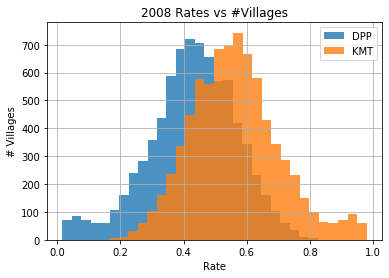

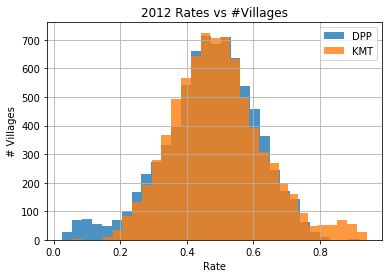

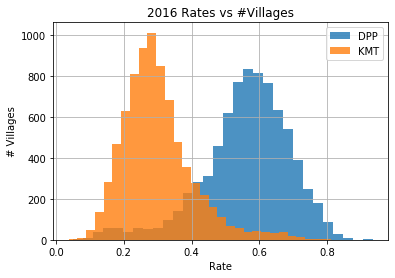

In [41]:
for year in [2008, 2012, 2016]:
    for party in ["DPP", "KMT"]:
        df = pd.read_sql_query("SELECT rate FROM rates WHERE year = {year} AND party = '{party}';".format(
            year = year, party = party
        ), conn)
        df.rate.hist(bins=30, alpha=0.8, label=party)
    plt.title("{year} Rates vs #Villages".format(year=year))
    plt.xlabel("Rate")
    plt.ylabel("# Villages")
    plt.legend()
    plt.show()

DPP-to-KMT by year.

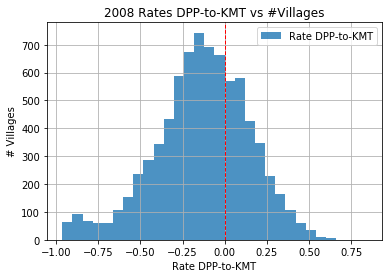

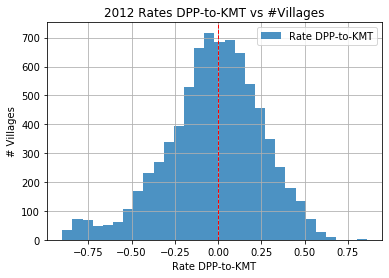

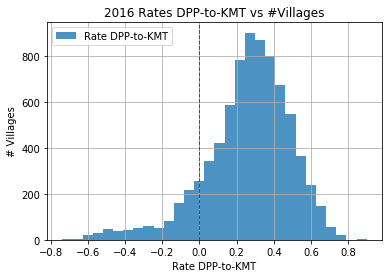

In [49]:
for year in [2008, 2012, 2016]:
    df = pd.read_sql_query(
        """
        SELECT rate - (
            SELECT rate FROM rates WHERE
               year = {year}
               AND city_county = r0.city_county
               AND township_city = r0.township_city
               AND village = r0.village
               AND party = 'KMT'
               LIMIT 1
               ) AS dpp_to_kmt_rate
            FROM rates AS r0 WHERE year = {year} AND party = 'DPP';
        """.format(year = year), conn)
    df.dpp_to_kmt_rate.hist(bins=30, alpha=0.8, label="Rate DPP-to-KMT")
    
    plt.axvline(0.00, color="red", linestyle="dashed", linewidth=1)
    plt.title("{year} Rates DPP-to-KMT vs #Villages".format(year=year))
    plt.xlabel("Rate DPP-to-KMT")
    plt.ylabel("# Villages")
    plt.legend()
    plt.show()

In [54]:
conn.execute("""
    CREATE TABLE dpp_to_kmt_rates AS
    SELECT city_county, township_city, village, year, rate - (
        SELECT rate FROM rates WHERE
           year = r0.year
           AND city_county = r0.city_county
           AND township_city = r0.township_city
           AND village = r0.village
           AND party = 'KMT'
           LIMIT 1
           ) AS dpp_to_kmt_rate
        FROM rates AS r0 WHERE party = 'DPP';
    """)

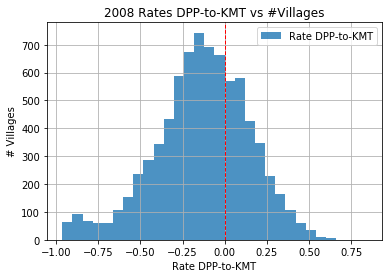

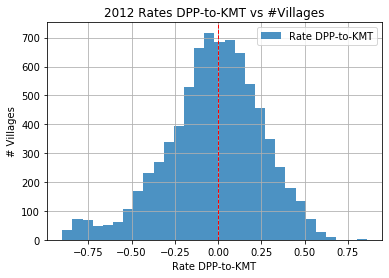

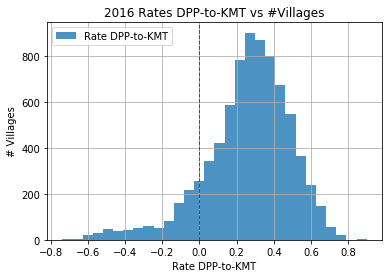

In [55]:
for year in [2008, 2012, 2016]:
    df = pd.read_sql_query(
        """
        SELECT * FROM dpp_to_kmt_rates WHERE year = {year};
        """.format(year = year), conn)
    df.dpp_to_kmt_rate.hist(bins=30, alpha=0.8, label="Rate DPP-to-KMT")
    
    plt.axvline(0.00, color="red", linestyle="dashed", linewidth=1)
    plt.title("{year} Rates DPP-to-KMT vs #Villages".format(year=year))
    plt.xlabel("Rate DPP-to-KMT")
    plt.ylabel("# Villages")
    plt.legend()
    plt.show()

DPP-to-KMT rate changes.

In [58]:
conn.execute("""
    CREATE TABLE dpp_to_kmt_rate_changes AS
        SELECT city_county, township_city, village,
            (SELECT dpp_to_kmt_rate FROM dpp_to_kmt_rates WHERE
                city_county = r0.city_county
                AND township_city = r0.township_city
                AND village = r0.village
                AND year = 2008
                LIMIT 1)
            AS dpp_to_kmt_rates_2008,
            (SELECT dpp_to_kmt_rate FROM dpp_to_kmt_rates WHERE
                city_county = r0.city_county
                AND township_city = r0.township_city
                AND village = r0.village
                AND year = 2012
                LIMIT 1)
            AS dpp_to_kmt_rates_2012,
            dpp_to_kmt_rate AS dpp_to_kmt_rates_2016
        FROM dpp_to_kmt_rates AS r0 WHERE year = 2016;
        """)

In [144]:
president_changes = pd.read_sql_query("""
    SELECT *,
    CONCAT(city_county, township_city, village) AS fullvill,
    dpp_to_kmt_rates_2012 - dpp_to_kmt_rates_2008 AS changes_at_2012,
    dpp_to_kmt_rates_2016 - dpp_to_kmt_rates_2012 AS changes_at_2016
    FROM dpp_to_kmt_rate_changes;
""", conn)

president_changes.to_csv(president_changes_csv, index=None)

In [145]:
president_changes.describe()

,dpp_to_kmt_rates_2008,dpp_to_kmt_rates_2012,dpp_to_kmt_rates_2016,changes_at_2012,changes_at_2016
count,4655.000000,7136.000000,7825.000000,4652.000000,7136.000000
mean,-0.148065,-0.015012,0.260528,0.104831,0.283073
std,0.291925,0.276377,0.231260,0.047480,0.075144
min,-0.956456,-0.900000,-0.736842,-0.310953,-0.237404
25%,-0.321813,-0.171315,0.149559,0.077022,0.237158
50%,-0.123994,0.007027,0.287951,0.102227,0.289366
75%,0.063638,0.173168,0.415556,0.130539,0.330860
max,0.699704,0.858238,0.898383,0.466117,0.709280


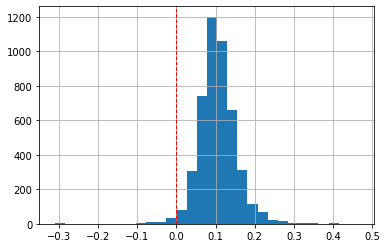

In [134]:
president_changes.changes_at_2012.hist(bins=30)
plt.axvline(0.00, color="red", linestyle="dashed", linewidth=1)
plt.show()

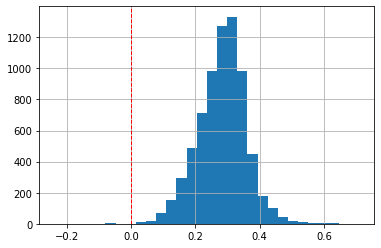

In [135]:
president_changes.changes_at_2016.hist(bins=30);
plt.axvline(0.00, color="red", linestyle="dashed", linewidth=1)
plt.show()

In [137]:
villages = \
    president_changes[president_changes.dpp_to_kmt_rates_2016 < 0.4][president_changes.changes_at_2016 < 0.1].sort_values("changes_at_2016"); villages

/Users/pm5/.local/share/virtualenvs/tracevotes-jrj40fyZ/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,city_county,township_city,village,dpp_to_kmt_rates_2008,dpp_to_kmt_rates_2012,dpp_to_kmt_rates_2016,changes_at_2012,changes_at_2016
6008,臺東縣,臺東市,豐樂里,NaN,0.267358,0.029954,NaN,-0.237404
7695,高雄市,鳳山區,中正里,NaN,-0.315183,-0.471684,NaN,-0.156501
973,宜蘭縣,宜蘭市,南津里,0.021552,0.095430,-0.028950,0.073878,-0.124380
957,宜蘭縣,大同鄉,太平村,0.020833,0.271186,0.186047,0.250353,-0.085140
7184,高雄市,大樹區,統嶺里,NaN,0.445585,0.381605,NaN,-0.063980
4015,澎湖縣,白沙鄉,小赤村,-0.070707,0.063158,0.100000,0.133865,0.036842
3109,新北市,貢寮區,吉林里,NaN,0.181818,0.221088,NaN,0.039270
3112,新北市,貢寮區,福連里,NaN,0.283358,0.335165,NaN,0.051806
2478,新北市,平溪區,東勢里,NaN,0.123839,0.179577,NaN,0.055739
6645,雲林縣,古坑鄉,湳仔村,0.195695,0.279923,0.340000,0.084228,0.060077


In [146]:
villages.city_county.value_counts()

雲林縣    5
高雄市    4
新北市    4
澎湖縣    3
嘉義縣    3
屏東縣    2
宜蘭縣    2
基隆市    1
臺東縣    1
苗栗縣    1
Name: city_county, dtype: int64

In [131]:
villages.to_csv(data_dir / "villages.csv", index=None)